In [1]:
import torch
import numpy as np

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
from matplotlib.path import Path
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 0
torch.manual_seed(seed)
data = torch.load("data/cake_data.pt")
model_data = torch.load("data/cake_model_data.pt")
X = data["X"]
Y = data["Y"]
num_objectives = Y.shape[-1]

model_X = model_data["x_grid"]
model_Y = model_data["mean"]
variance = model_data["variance"]
model_pareto_mask = model_data["pareto_mask"]
plot_grid_length = model_data["plot_grid_length"]
model_pareto_surface = model_data["mean_surface"].reshape(
    plot_grid_length, plot_grid_length, num_objectives
)
nadir = model_data["nadir"]
utopia = model_data["utopia"]

In [3]:
# Solve RTS and STR problem.
target = torch.tensor([-360.00, 4.00, 1.00], **tkwargs)
weight = torch.tensor([0.004, 0.155, 0.841], **tkwargs)
utopia_eff = weight * target
mean_diff = torch.sum((weight * model_Y - utopia_eff) ** 2, dim=-1)
scaled_variance = torch.sum(weight**2 * variance, dim=-1)

betas = torch.tensor([0.0, 1.00], **tkwargs)
indices = []
vals = []

best_inputs = torch.zeros(len(betas), model_X.shape[-1], **tkwargs)
best_outputs = torch.zeros(len(betas), model_Y.shape[-1], **tkwargs)
for i, beta in enumerate(betas):
    obj = mean_diff + beta * scaled_variance
    index = obj.argmin()
    best_inputs[i, ...] = model_X[index]
    best_outputs[i, ...] = model_Y[index]

    indices.append(index)
    vals.append(obj[index])

In [4]:
input_bounds = torch.row_stack([X.min(dim=0).values, X.max(dim=0).values])
output_bounds = torch.row_stack([Y.min(dim=0).values, Y.max(dim=0).values])

# Get Pareto points.
pareto_model_Y = model_Y[model_pareto_mask]
pareto_model_X = model_X[model_pareto_mask]
non_pareto_model_Y = model_Y[~model_pareto_mask]
non_pareto_model_X = model_X[~model_pareto_mask]

# Set up parallel coordinates plot.
non_pareto_XY = torch.column_stack([pareto_model_X, pareto_model_Y]).detach().numpy()
pareto_XY = (
    torch.column_stack([non_pareto_model_X, non_pareto_model_Y]).detach().numpy()
)
rts_XY = torch.column_stack([best_inputs[0:1], best_outputs[0:1]]).detach().numpy()
str_XY = torch.column_stack([best_inputs[1:], best_outputs[1:]]).detach().numpy()

ys = np.row_stack([pareto_XY, rts_XY, str_XY])
categories = np.array([1 for _ in range(len(pareto_XY))] + [2] + [3])
alphas = np.array([1.0 / 510 for _ in range(len(pareto_XY))] + [1] + [1])
linewidths = np.array([1.0 for _ in range(len(pareto_XY))] + [3.0] + [3.0])

dys = ys.max(axis=0) - ys.min(axis=0)
ymins = ys.min(axis=0) - dys * 0.05
ymaxs = ys.max(axis=0) + dys * 0.05

zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

colors = ["crimson", "deepskyblue", "lawngreen"]
ylabels = [
    "Wheat \n flour",
    "Spelt \n flour",
    "Sugar",
    "Chocolate",
    "Nuts",
    "Carrot",
    "Negative \n calories",
    "Taste",
    "Browning",
]

rts_Y = best_outputs[0:1].detach().numpy()
str_Y = best_outputs[1:].detach().numpy()
pareto_model_Y = pareto_model_Y.detach().numpy()
non_pareto_model_Y = non_pareto_model_Y.detach().numpy()
model_pareto_surface = model_pareto_surface.detach().numpy()
nadir = nadir.detach().numpy()
utopia = utopia.detach().numpy()

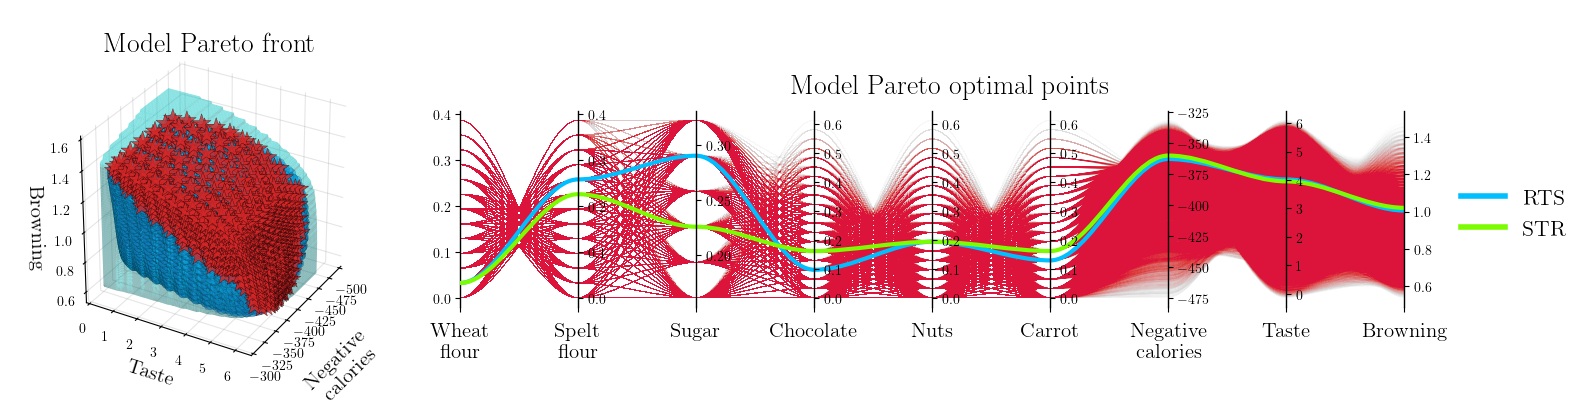

In [5]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.remove()
plt.rcParams["grid.color"] = (0.5, 0.5, 0.5, 0.2)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0.6, hspace=0.1)

gs = fig.add_gridspec(4, 12)
##################################################################################
ax = fig.add_subplot(gs[0:4, 0:4], projection="3d")

ax.scatter(
    xs=pareto_model_Y[:, 0],
    ys=pareto_model_Y[:, 1],
    zs=pareto_model_Y[:, 2],
    marker="*",
    color="tab:red",
    s=200,
    alpha=0.8,
    edgecolors="k",
    linewidth=0.25,
)

ax.scatter(
    xs=rts_Y[:, 0],
    ys=rts_Y[:, 1],
    zs=rts_Y[:, 2],
    marker="*",
    color="mediumseagreen",
    s=200,
    alpha=1.0,
    edgecolors="k",
    linewidth=1.0,
    zorder=5,
)

ax.scatter(
    xs=str_Y[:, 0],
    ys=str_Y[:, 1],
    zs=str_Y[:, 2],
    marker="*",
    color="tab:purple",
    s=200,
    alpha=1.0,
    edgecolors="k",
    linewidth=1.0,
    zorder=5,
)
ax.scatter(
    xs=non_pareto_model_Y[:, 0],
    ys=non_pareto_model_Y[:, 1],
    zs=non_pareto_model_Y[:, 2],
    color="dodgerblue",
    marker="o",
    s=50,
    alpha=0.5,
    edgecolors="k",
    linewidth=0.25,
)

surf = ax.plot_surface(
    model_pareto_surface[..., 0],
    model_pareto_surface[..., 1],
    model_pareto_surface[..., 2],
    alpha=0.5,
    rstride=1,
    cstride=1,
    color="cyan",
    shade=True,
)

ax.scatter(
    xs=nadir[0],
    ys=nadir[1],
    zs=nadir[2],
    color="w",
    marker="s",
    linestyle="None",
    s=100,
    edgecolors="k",
    linewidth=1.5,
    zorder=5,
)

ax.view_init(30, 30)
ax.set_box_aspect(aspect=(1, 1, 1), zoom=0.8)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor("w")
ax.yaxis.pane.set_edgecolor("w")
ax.zaxis.pane.set_edgecolor("w")

ax.set_xlim(-500, -300)
ax.set_ylim(0, 6.5)
ax.set_zlim(0.55, 1.6)

ax.set_xlabel("Negative \n calories", fontsize=15, labelpad=20)
ax.set_ylabel("Taste", fontsize=15, labelpad=5)
ax.set_zlabel("Browning", fontsize=15, labelpad=5)
ax.set_title(r"Model Pareto front", size=20, y=0.95)
plt.rcParams["grid.color"] = (0.5, 0.5, 0.5, 0.1)
##################################################################################
main_axes = fig.add_subplot(gs[1:3, 5:12])

axes = [main_axes] + [main_axes.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    if ax != main_axes:
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("right")
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))
    ax.spines["left"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)

main_axes.set_xlim(0, ys.shape[1] - 1)
main_axes.set_xticks(range(ys.shape[1]))
main_axes.set_xticklabels(ylabels, fontsize=15)
main_axes.tick_params(axis="x", which="major", pad=7)
main_axes.spines["right"].set_visible(False)
main_axes.set_title(r"Model Pareto optimal points", fontsize=20, x=0.52, y=1.05)

# Create Bezier curves.
for j in range(len(ys)):

    verts = list(
        zip(
            [x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
            np.repeat(zs[j, :], 3)[1:-1],
        )
    )
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = mpatches.PathPatch(
        path,
        facecolor="none",
        lw=linewidths[j],
        edgecolor=colors[categories[j] - 1],
        alpha=alphas[j],
        zorder=categories[j],
    )
    main_axes.add_patch(patch)

blue_line = mlines.Line2D(
    [], [], color="deepskyblue", linestyle="-", linewidth=4, label="RTS"
)
green_line = mlines.Line2D(
    [], [], color="lawngreen", linestyle="-", linewidth=4, label="STR"
)

ax.legend(
    handles=[
        (blue_line),
        (green_line),
    ],
    ncol=1,
    fontsize=16,
    loc=(1.05, 0.3),
    facecolor="k",
    framealpha=0.00,
)

plt.show()